In [60]:
## improt function
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import random
import argparse
import math
import itertools
from time import time
from collections import defaultdict, Counter
import re
import string



import nltk.classify
import nltk
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.tokenize import word_tokenize 

import sklearn
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB





np.random.seed(42)
tf.random.set_seed(42)

In [61]:
#import data
df = pd.read_csv('C:/Users/suphanat/vaccine_classify-24Apr.csv', encoding='latin1')
print(df.columns)
df = df.loc[(df['Classify']==0) | (df['Classify']==1)]
df

Index(['screen_name', 'text', 'Classify', 'source', 'is_quote'], dtype='object')


,screen_name,text,Classify,source,is_quote
0,Zupdood,@RatchetNurse1 @seanilling Me too. Didn??t r...,1.0,Twitter for iPhone,False
1,yapplebee,@jeffreyhoward33 I had my 2nd Pfizer Monday mo...,1.0,Twitter Web App,False
2,yacousinvinnie,so the 2nd Moderna shot got me. I??m just wak...,1.0,Twitter for iPhone,False
3,yacousinvinnie,"@Kevtown2 just a lot of body aches, some chill...",1.0,Twitter for iPhone,False
4,Xunder_oathX,@iLadySwoop The first I had a sore arm. Second...,1.0,Twitter for Android,False
...,...,...,...,...,...
1323,_Fake_Genius_,@Rajesh_2916 Still keep checking O2. Its gold ...,0.0,Twitter for Android,False
1324,_Brian_ICT,It wasn??t cat scratch fever. https://t.co/2q...,0.0,Twitter for iPhone,True
1325,_babygroot_,@sapnamadan I'm good. No fever or weakness as ...,0.0,Twitter for Android,False
1326,_assiyah_,Just realized this whole year has been a fever...,0.0,Twitter for iPhone,False


In [62]:
text_pre=[]
for i in df['text']:
    pre = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",i).split())
    text_pre.append(pre)
df['text_pre'] = text_pre

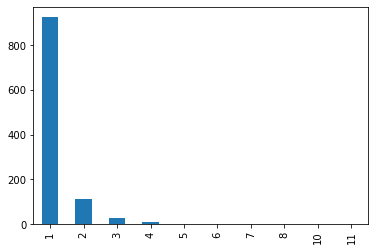

In [63]:
#describe data
label_counts = df['Classify'].value_counts()

source_counts = df['source'].value_counts()

name_counts = df['screen_name'].value_counts()

name_counts.value_counts().sort_index(ascending=True).plot.bar()

plt.show()

In [94]:
#define function for feature extraction
def get_features(train_data, test_data, features_selection):
    """
    Wrapper function for applying a number of feature functions to the data
    in the train and test splits.

    :param list train_data: List of raw training example data.
    :param list test_data: List of raw testing example data.
    :param str features_selection: Name of selected Features.
    :returns: Features for each example.
    :rtype: list
    """
    # Notice we only obtain the vocabularies from the training data.
    # Why shouldn't we get them from the test data too?
    
    ### get vocabulary for featrures
    
    vocabulary = get_vocabulary(train_data)

    
    if features_selection == "Part of Speech Tagging" or "Combinded Features":
        pos_vocabulary = get_pos_vocabulary(train_data)



    # (train_features, test_features)
    feature_sets = ([], [])
    for (i, example_set) in enumerate([train_data, test_data]):
        for example in example_set:
            # Add new features in this loop.
            document = example
            
            if features_selection == "Bag of Words":
                bow_feature = get_bag_of_words_features(document, vocabulary)
                feat =  {**bow_feature}
                feature_sets[i].append(feat)
                
            elif features_selection == "Part of Speech Tagging":
                pos_feature = get_pos(document, pos_vocabulary)
                feat =  {**pos_feature}
                feature_sets[i].append(feat)  
                
            elif features_selection == "Embedded":
                embedder_feature = embedder(document)  
                feat =  {**embedder_feature}
                feature_sets[i].append(feat)  
                
            else:
                print("please enter your feature")
                
    return feature_sets


def get_vocabulary(examples):
    """
    Get the set of unique words from the text data in examples.
    Used by get_bag_of_words_features().

    :param list examples: List of example data, each of which is
                          a list with plain text data at example[5].
    :returns: Set of unique words.
    :rtype: list
    """
    tokens = [word.lower() for example in examples
              for word in nltk.word_tokenize(example)]    
    vocabulary = nltk.FreqDist(t for t in tokens)
    return list(vocabulary)[:2000]


def get_bag_of_words_features(document, vocabulary):
    """
    Bag of words representation of the text in the specified document.

    :param str document: Plain text.
    :param list vocabulary: The unique set of words across all documents.
    :returns: Bag of words features for this document.
    :rtype: dict
    """
    document_words = set(nltk.word_tokenize(document.lower()))
    features = {}
    for word in vocabulary:
        features[f"contains({word})"] = (word in document_words)
    return features


def get_pos_vocabulary(examples):
    """
        Get the set of unique POS from the text data in examples.
        Used by get_pos().

        :param list examples: List of example data, each of which is
                              a list with plain text data at example[5].
        :returns: Set of POS words.
        :rtype: list
    """
    tokens = [word for example in examples
             for word in nltk.pos_tag(nltk.word_tokenize(example))]
                       
    pos = [word[1] for word in tokens]
    pos_vocabulary = nltk.FreqDist(t for t in pos)
    return list(pos_vocabulary)

                       
def get_pos(sentence, pos_vocabulary):
    """
        POS tag identify pos in sentence.

        :param str sentence: Plain text.
        :param list pos_vocabulary: The unique set of POS across all documents.
        :returns: POS features for this document.
        :rtype: dict
    """
    sentence = sentence.split()
    features = {}
    pos = nltk.pos_tag(sentence)
    pos_word_window = [word[1] for word in pos]
                       
    for word in pos_vocabulary:
        features[f"contains({word})"] = (word in pos_word_window)
    return features



def cross_validation_folds(num_folds, data_size):
    """
    DO NOT MODIFY THIS FUNCTION!

    Given the desired number of cross validation folds and a dataset size
    returns a generator of start, end indices for the test data partitions.

    :param int num_folds: An integer >0 specifying the number of folds.
    :param int data_size: The number of examples in the dataset.
    :returns: Generator of start, end index tuples.
    """
    fold_size = data_size // num_folds
    test_start = 0
    test_end = fold_size
    for k in range(num_folds):
        test_start = fold_size * k
        test_end = test_start + fold_size
        if (k + 1) == num_folds:
            test_end = data_size
        yield test_start, test_end


def evaluate(predictions, gold_labels):
    """
    DO NOT MODIFY THIS FUNCTION!

    Given a model's predictions and the gold standard labels,
    compute the precision, recall, and F1 score of the predictions.

    :param list predictions: Predicted labels.
    :param list gold_labels: Gold standard labels.
    :returns: precision, recall, F1
    :rtype: (float, float, float)
    """
    if len(predictions) != len(gold_labels):
        raise ValueError("Number of predictions and gold labels differ.")
    prec, rec, f1, _ = precision_recall_fscore_support(predictions,
                                                       gold_labels,
                                                       average="macro",
                                                       zero_division=0)
    return prec, rec, f1

def evaluate_micro(predictions, gold_labels):
    """
    DO NOT MODIFY THIS FUNCTION!

    Given a model's predictions and the gold standard labels,
    compute the precision, recall, and F1 score of the predictions.

    :param list predictions: Predicted labels.
    :param list gold_labels: Gold standard labels.
    :returns: precision, recall, F1
    :rtype: (float, float, float)
    """
    if len(predictions) != len(gold_labels):
        raise ValueError("Number of predictions and gold labels differ.")
    prec, rec, f1, _ = precision_recall_fscore_support(predictions,
                                                       gold_labels,
                                                       average="micro",
                                                       zero_division=0)
    return prec, rec, f1

def results_summary(precs, recs, f1s, Classifiers_select, Features_select):
    """
    Prints a table of precision, recall, and F1 scores for each
    cross validation fold, as well as the average over the folds.

    :param list precs: The precisions for each fold.
    :param list recs: The recalls for each fold.
    :param list f1s: The F1 scores for each fold.
    :param str Classifiers_select: Name of selected classifier
    :param str Features_select: Name of selected features

    """
    assert len(precs) == len(recs) == len(f1s)
    n_folds = len(precs)
    folds_strs = [f"Fold {i+1: <3}" for i in range(n_folds)]
    folds_str = ' '.join(f"{fold_str: <10}" for fold_str in folds_strs)
    precs_str = ' '.join(f"{prec: <10.2f}" for prec in precs)
    precs_avg = sum(precs) / len(precs)
    recs_str = ' '.join(f"{rec: <10.2f}" for rec in recs)
    recs_avg = sum(recs) / len(recs)
    f1s_str = ' '.join(f"{f1: <10.2f}" for f1 in f1s)
    f1s_avg = sum(f1s) / len(f1s)
    outstr = ""
    outstr += f"############## Featuere: " + str(Features_select) +  ",  Classifier: " + str(Classifiers_select) + f"###############\n"
    outstr += f"{'': <13} " + folds_str + f"{'Average': <10}\n"
    outstr += f"{'Precision': <15}" + precs_str + f"{precs_avg: <10.2f}\n"
    outstr += f"{'Recall': <15}" + recs_str + f"{recs_avg: <10.2f}\n"
    outstr += f"{'F1 score': <15}" + f1s_str + f"{f1s_avg: <10.2f}\n"
    outstr += f"\n"
    outstr += f"\n"
    return outstr

def encode(sentences, labels, embedder):
    X = embedder(sentences)  # Features, AKA embeddings
    y = labels # Labels
    return X, y

In [90]:
#define class for FFNN
class FFNN(object):
    """
    A feed-forward neural network.

    n_features (int): the input dimension.
    n_classes (int): the number of output classes. Use 1 or 2 for binary tasks.
    embedding_url: if not None, download and incorporate the embedding model
                   from the provided tensorflow hub URL.
    n_hidden_1: the number of hidden units in the first layer.
    n_hidden_2: the number of hidden units in the second layer.
    epochs: the number of epochs to train for.
    batch_size: the number of examples to send to the net at once.
    dropout_rate: how often to drop examples in the dropout layer.
    learning_rate: how quickly to follow the training gradient.
    """

    def __init__(self, n_features, n_classes, embedding_url=None,
                 n_hidden_1=64, n_hidden_2=32, epochs=10,
                 batch_size=32, dropout_rate=0.2, learning_rate=0.001):
        self.n_features = n_features
        self.n_classes = 1 if n_classes == 2 else n_classes
        self.embedding_url = embedding_url
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.epochs = epochs
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self._get_model()

    def _get_model(self):
        if self.n_classes in [1, 2]:
            out_activation = "sigmoid"
            loss = "binary_crossentropy"
        else:
            out_activation = "softmax"
            loss = "categorical_crossentropy"

        embed = []
        if self.embedding_url is not None:
            embed = [hub.KerasLayer(self.embedding_url, input_shape=[],
                                    dtype=tf.string, trainable=False)]

        self.model = tf.keras.models.Sequential([
            *embed,
            tf.keras.layers.Dense(self.n_hidden_1, input_dim=self.n_features,
                                  activation="relu"),
            tf.keras.layers.Dense(self.n_hidden_2, input_dim=self.n_hidden_1,
                                  activation="relu"),
            tf.keras.layers.Dropout(rate=self.dropout_rate),
            tf.keras.layers.Dense(self.n_classes,
                                  activation=out_activation)
        ])

        opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        metrics = [tf.keras.metrics.Precision(name="precision"),
                   tf.keras.metrics.Recall(name="recall")]
        self.model.compile(optimizer=opt,
                           loss=loss,
                           metrics=metrics)
        print(self.model)

    def fit(self, X, y, callbacks=None, **kwargs):
        """
        Train the model on some data.

        X: A numpy array of training examples x features
        y: A numpy array of training labels.
        """
        self.model.fit(X, y,
                       epochs=self.epochs,
                       batch_size=self.batch_size,
                       callbacks=callbacks)

    def predict(self, X, classes=True):
        """
        Predict the test data.

        X: a numpy array of test examples x features
        classes: if True, predict class labels. Predict real values.
        """
        if classes is True:
            return tf.squeeze(self.model.predict_classes(X)).numpy()
        else:
            return self.model.predict(X)



In [95]:
##Perform analysis, print and export final results with un-processing data

### List of Classifier ###
Classifier=["Logistic Regression","Decision Tree","Naive Bayes","SVM","FFNN"]

### List of Features ###
Features=["Bag of Words","Part of Speech Tagging","Embedded"]

Model = list(itertools.product(Features,Classifier))
summary_base = ""

df = df.sample(frac=1).reset_index(drop=True)
data = df['text']
labels = df['Classify']

### Loop all features and classifiers
for x in Model:
    Classifiers_select = x[1]
    Features_select = x[0]
    precs = []
    recs = []
    f1s = []
    fold = 1
    print(f"Classifier:" + str(Classifiers_select))
    print(f"Feature:" + str(Features_select))
    print(f"Running training and evaluation on {len(data)} examples.")
    for test_start, test_end in cross_validation_folds(5, len(data)):
        print(f"Fold: {fold}  ", end='', flush=True)
        fold += 1
        test_data = data[test_start:test_end]
        test_labels = labels[test_start:test_end]
        train_data = data[test_start:].append(data[test_end:])
        train_labels = labels[test_start:].append(labels[test_end:])
        
        # Change get_features() to implement your own feature functions.
        if Features_select == "Embedded":             
            train_data = train_data.values
            train_labels = train_labels.values
            test_data = test_data.values
            test_labels = test_labels.values
            
            EMBED_URL = "https://tfhub.dev/google/nnlm-en-dim128/2"  # The embedding model.
            print("Getting embedding model...", end='')
            embedder = hub.KerasLayer(EMBED_URL, dtype=tf.string, trainable=False) # The Layer, which does the transformation.
            print("Done")
            
            train_X, train_y = encode(train_data, train_labels, embedder)
            test_X, test_y = encode(test_data, test_labels, embedder)
            
            train_examples = zip(train_X, train_y)
            classifier = Classifiers_select 

            # Change this line to try different models.

            if classifier == "Naive Bayes":
                trained_classifier = GaussianNB().fit(train_X, train_y)
            elif classifier == "SVM":
                trained_classifier = LinearSVC(random_state=42).fit(train_X, train_y)
            elif classifier == "Decision Tree":
                trained_classifier = DecisionTreeClassifier(random_state=42).fit(train_X, train_y)
                #trained_classifier = nltk.DecisionTreeClassifier.train(train_X, train_y)
            elif classifier == "Conditional Exponential":
                trained_classifier = nltk.ConditionalExponentialClassifier.train(list(train_examples), max_iter=10)
            elif classifier == "Logistic Regression":
                trained_classifier = LogisticRegression(random_state=42).fit(train_X, train_y)
            elif classifier == "FFNN":
                trained_classifier = FFNN(n_features=train_X.shape[1], n_classes=2, epochs =50)
                trained_classifier.fit(train_X, train_y)

                
            start = time()
            end = time()
            train_time = end - start
            print(f"{train_time:.1f} ", end='', flush=True)
            print("evaluating...", end='', flush=True)
            start = time()
            predictions = trained_classifier.predict(test_X)
            end = time()
            prec, rec, f1 = evaluate(test_y, predictions)
            precs.append(prec)
            recs.append(rec)
            f1s.append(f1)
            eval_time = end - start
            print(f"{eval_time:.1f} ", end='', flush=True)
            print("done\n")          
            
        else:
            train_feats, test_feats = get_features(train_data, test_data, Features_select)
            print("training...", end='', flush=True)
            start = time()
            train_examples = zip(train_feats, train_labels)
            classifier = Classifiers_select 
            # Change this line to try different models.

            if classifier == "Naive Bayes":
                trained_classifier = nltk.NaiveBayesClassifier.train(train_examples)
                predictions = trained_classifier.classify_many(test_feats)
            elif classifier == "SVM":
                svm_classifier = nltk.classify.SklearnClassifier(LinearSVC())
                trained_classifier = svm_classifier.train(train_examples)
                predictions = trained_classifier.classify_many(test_feats)

            elif classifier == "Decision Tree":
                trained_classifier = nltk.DecisionTreeClassifier.train(list(train_examples))
                predictions = trained_classifier.classify_many(test_feats)
            elif classifier == "Logistic Regression":
                svm_classifier = nltk.classify. SklearnClassifier(LogisticRegression())
                trained_classifier = svm_classifier.train(train_examples)
                predictions = trained_classifier.classify_many(test_feats)
            elif classifier == "FFNN":                          
                train_feats_x = pd.DataFrame(train_feats)
                train_feats_y = pd.DataFrame(train_labels)
                test_feats_x = pd.DataFrame(test_feats)
                trained_classifier = FFNN(n_features=train_feats_x.shape[1], n_classes=2, epochs =50)
                trained_classifier.fit(train_feats_x, train_feats_y)
                predictions = trained_classifier.predict(test_feats_x)

            start = time()
            end = time()
            train_time = end - start
            print(f"{train_time:.1f} ", end='', flush=True)
            print("evaluating...", end='', flush=True)
            start = time()
            end = time()
            prec, rec, f1 = evaluate(test_labels, predictions)
            precs.append(prec)
            recs.append(rec)
            f1s.append(f1)
            eval_time = end - start
            print(f"{eval_time:.1f} ", end='', flush=True)
            print("done\n")            
    summary = results_summary(precs, recs, f1s, Classifiers_select, Features_select) 
    summary_base = summary_base + summary
print(summary_base)
with open("C:/Users/suphanat/vaccine_classify_evaluate.txt", 'w') as outF:
    outF.write(summary_base)


Classifier:Logistic Regression
Feature:Bag of Words
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:Decision Tree
Feature:Bag of Words
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:Naive Bayes
Feature:Bag of Words
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Cla

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002474DBAAF70>
Epoch 1/50
59/59 [==============================] - 1s 2ms/step - loss: 0.6065 - precision: 0.4924 - recall: 0.2103
Epoch 2/50
59/59 [==============================] - 0s 2ms/step - loss: 0.2069 - precision: 0.9344 - recall: 0.8539
Epoch 3/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0710 - precision: 0.9756 - recall: 0.9695
Epoch 4/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0310 - precision: 0.9916 - recall: 0.9913
Epoch 5/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0122 - precision: 0.9979 - recall: 0.9994
Epoch 6/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0075 - precision: 0.9998 - recall: 0.9992
Epoch 7/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0079 - precision: 1.0000 - recall: 0.9973
Epoch 8/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0044 - precision: 1

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x00000247CD85ED90>
Epoch 1/50
42/42 [==============================] - 1s 2ms/step - loss: 0.6278 - precision: 0.5029 - recall: 0.6412
Epoch 2/50
42/42 [==============================] - 0s 2ms/step - loss: 0.2370 - precision: 0.9222 - recall: 0.8789
Epoch 3/50
42/42 [==============================] - 0s 3ms/step - loss: 0.0765 - precision: 0.9907 - recall: 0.9681
Epoch 4/50
42/42 [==============================] - 0s 3ms/step - loss: 0.0338 - precision: 0.9998 - recall: 0.9901
Epoch 5/50
42/42 [==============================] - 0s 3ms/step - loss: 0.0283 - precision: 1.0000 - recall: 0.9909
Epoch 6/50
42/42 [==============================] - 0s 3ms/step - loss: 0.0199 - precision: 1.0000 - recall: 0.9899
Epoch 7/50
42/42 [==============================] - 0s 3ms/step - loss: 0.0093 - precision: 1.0000 - recall: 0.9970
Epoch 8/50
42/42 [==============================] - 0s 3ms/step - loss: 0.0059 - precision: 1

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000024719376640>
Epoch 1/50
26/26 [==============================] - 1s 2ms/step - loss: 0.6269 - precision: 0.6372 - recall: 0.1382
Epoch 2/50
26/26 [==============================] - 0s 2ms/step - loss: 0.3793 - precision: 0.9979 - recall: 0.5564
Epoch 3/50
26/26 [==============================] - 0s 2ms/step - loss: 0.1511 - precision: 0.9908 - recall: 0.9716
Epoch 4/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0483 - precision: 0.9980 - recall: 0.9946
Epoch 5/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0244 - precision: 1.0000 - recall: 0.9966
Epoch 6/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0106 - precision: 1.0000 - recall: 0.9995
Epoch 7/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0226 - precision: 1.0000 - recall: 0.9909
Epoch 8/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0098 - precision: 1

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002474DBDE8E0>
Epoch 1/50
9/9 [==============================] - 1s 3ms/step - loss: 0.6926 - precision: 0.2119 - recall: 0.2187
Epoch 2/50
9/9 [==============================] - 0s 2ms/step - loss: 0.6139 - precision: 0.9218 - recall: 0.1810
Epoch 3/50
9/9 [==============================] - 0s 2ms/step - loss: 0.5280 - precision: 1.0000 - recall: 0.3057
Epoch 4/50
9/9 [==============================] - 0s 2ms/step - loss: 0.4215 - precision: 1.0000 - recall: 0.5372
Epoch 5/50
9/9 [==============================] - 0s 2ms/step - loss: 0.3342 - precision: 0.9941 - recall: 0.8392
Epoch 6/50
9/9 [==============================] - 0s 2ms/step - loss: 0.2119 - precision: 1.0000 - recall: 0.9171
Epoch 7/50
9/9 [==============================] - 0s 2ms/step - loss: 0.1344 - precision: 1.0000 - recall: 0.9713
Epoch 8/50
9/9 [==============================] - 0s 2ms/step - loss: 0.0776 - precision: 1.0000 - recall: 

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:Decision Tree
Feature:Part of Speech Tagging
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:Naive Bayes
Feature:Part of Speech Tagging
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:SVM
Feature:Part of Speech Tagging
Running training and evaluation on 1328 examples

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000024721AFCE80>
Epoch 1/50
59/59 [==============================] - 1s 821us/step - loss: 0.6574 - precision: 0.1377 - recall: 0.0382
Epoch 2/50
59/59 [==============================] - 0s 925us/step - loss: 0.5370 - precision: 0.5896 - recall: 0.1751
Epoch 3/50
59/59 [==============================] - 0s 996us/step - loss: 0.4535 - precision: 0.6835 - recall: 0.4121
Epoch 4/50
59/59 [==============================] - 0s 1ms/step - loss: 0.4435 - precision: 0.6650 - recall: 0.5557
Epoch 5/50
59/59 [==============================] - 0s 1ms/step - loss: 0.4366 - precision: 0.6530 - recall: 0.5859
Epoch 6/50
59/59 [==============================] - 0s 1ms/step - loss: 0.4209 - precision: 0.6308 - recall: 0.5497
Epoch 7/50
59/59 [==============================] - 0s 1ms/step - loss: 0.4195 - precision: 0.6743 - recall: 0.6151
Epoch 8/50
59/59 [==============================] - 0s 1ms/step - loss: 0.4371 - precis

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x00000247A558EDC0>
Epoch 1/50
42/42 [==============================] - 1s 813us/step - loss: 0.6537 - precision: 0.2762 - recall: 0.1550
Epoch 2/50
42/42 [==============================] - 0s 852us/step - loss: 0.5488 - precision: 0.6743 - recall: 0.2081
Epoch 3/50
42/42 [==============================] - 0s 973us/step - loss: 0.4979 - precision: 0.6233 - recall: 0.3698
Epoch 4/50
42/42 [==============================] - 0s 884us/step - loss: 0.4688 - precision: 0.6358 - recall: 0.4973
Epoch 5/50
42/42 [==============================] - 0s 902us/step - loss: 0.4375 - precision: 0.6873 - recall: 0.5526
Epoch 6/50
42/42 [==============================] - 0s 851us/step - loss: 0.4168 - precision: 0.6895 - recall: 0.5575
Epoch 7/50
42/42 [==============================] - 0s 973us/step - loss: 0.4095 - precision: 0.6739 - recall: 0.5693
Epoch 8/50
42/42 [==============================] - 0s 873us/step - loss: 0.387

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002474BCED220>
Epoch 1/50
26/26 [==============================] - 1s 838us/step - loss: 0.6616 - precision: 0.3761 - recall: 0.3205
Epoch 2/50
26/26 [==============================] - 0s 1ms/step - loss: 0.6178 - precision: 0.8148 - recall: 0.0134    
Epoch 3/50
26/26 [==============================] - 0s 982us/step - loss: 0.5957 - precision: 0.6315 - recall: 0.0700  
Epoch 4/50
26/26 [==============================] - 0s 877us/step - loss: 0.5480 - precision: 0.6983 - recall: 0.0843  
Epoch 5/50
26/26 [==============================] - 0s 957us/step - loss: 0.5080 - precision: 0.6625 - recall: 0.4361
Epoch 6/50
26/26 [==============================] - 0s 918us/step - loss: 0.4990 - precision: 0.6269 - recall: 0.3643
Epoch 7/50
26/26 [==============================] - 0s 997us/step - loss: 0.4963 - precision: 0.7546 - recall: 0.2895
Epoch 8/50
26/26 [==============================] - 0s 1ms/step - loss: 0

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002474BCED640>
Epoch 1/50
9/9 [==============================] - 1s 1ms/step - loss: 0.6578 - precision: 0.3632 - recall: 0.2375
Epoch 2/50
9/9 [==============================] - 0s 873us/step - loss: 0.6399 - precision: 0.4748 - recall: 0.0928
Epoch 3/50
9/9 [==============================] - 0s 1ms/step - loss: 0.6308 - precision: 0.9000 - recall: 0.0371
Epoch 4/50
9/9 [==============================] - 0s 1ms/step - loss: 0.6046 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/50
9/9 [==============================] - 0s 873us/step - loss: 0.6124 - precision: 0.5200 - recall: 0.0339  
Epoch 6/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5812 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5535 - precision: 1.0000 - recall: 0.0709
Epoch 8/50
9/9 [==============================] - 0s 992us/step - loss: 0.5663 - prec

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Done
0.0 evaluating...0.0 done

Fold: 2  Getting embedding model...WARNING:tensorflow:5 out of the last 6 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247C27BAA60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 3  Getting embedding model...

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Done


0.0 evaluating...0.0 done

Fold: 4  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247C27BAB80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 5  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247C2C17DC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Classifier:Decision Tree
Feature:Embedded
Running training and evaluation on 1328 examples.
Fold: 1  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x0000024785B9E040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 2  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A28B1280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 3  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002471A5EE4C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 4  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247192A8700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 5  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247C753C940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Classifier:Naive Bayes
Feature:Embedded
Running training and evaluation on 1328 examples.
Fold: 1  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247C2780EE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

    outputs = functional_ops.partitioned_call(
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\functional_ops.py", line 1206, in partitioned_call
    f.add_to_graph(graph)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\function.py", line 505, in add_to_graph
    g._add_function(self)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py", line 3395, in _add_function
    pywrap_tf_session.TF_GraphCopyFunction(self._c_graph, function._c_func.func,
tensorflow.python.framework.errors_impl.InvalidArgumentError: 'func' argument to TF_GraphCopyFunction cannot be null
Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_

    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\function.py", line 2969, in _get_concrete_function_internal_garbage_collected
    graph_function, _ = self._maybe_define_function(args, kwargs)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\function.py"

Done


0.0 evaluating...0.0 done

Fold: 2  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247C2B0AD30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 3  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x000002478C217F70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 4  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247147A31F0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 5  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002471958F430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Classifier:SVM
Feature:Embedded
Running training and evaluation on 1328 examples.
Fold: 1  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A1B12670> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 2  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A53888B0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 3  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247C753C3A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Done


0.0 evaluating...0.0 done

Fold: 4  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x000002478E4FDAF0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 5  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x000002478E51ED30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Classifier:FFNN
Feature:Embedded
Running training and evaluation on 1328 examples.
Fold: 1  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x0000024794256F70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


Epoch 1/50
75/75 [==============================] - 1s 1ms/step - loss: 0.6449 - precision: 0.3268 - recall: 0.2043
Epoch 2/50
75/75 [==============================] - 0s 926us/step - loss: 0.4166 - precision: 0.7950 - recall: 0.4525
Epoch 3/50
75/75 [==============================] - 0s 1ms/step - loss: 0.3333 - precision: 0.8019 - recall: 0.6944
Epoch 4/50
75/75 [==============================] - 0s 965us/step - loss: 0.2701 - precision: 0.8510 - recall: 0.7691
Epoch 5/50
75/75 [==============================] - 0s 996us/step - loss: 0.2638 - precision: 0.8389 - recall: 0.8058
Epoch 6/50
75/75 [==============================] - 0s 1ms/step - loss: 0.2429 - precision: 0.8526 - recall: 0.7845
Epoch 7/50
75/75 [==============================] - 0s 932us/step - loss: 0.2076 - precision: 0.8736 - recall: 0.8385
Epoch 8/50
75/75 [==============================] - 0s 890us/step - loss: 0.1792 - precision: 0.9161 - recall: 0.8292
Epoch 9/50
75/75 [==============================] - 0s 895us/s

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Done


Epoch 1/50


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

59/59 [==============================] - 2s 894us/step - loss: 0.6307 - precision: 0.2404 - recall: 0.0521
Epoch 2/50
59/59 [==============================] - 0s 828us/step - loss: 0.4641 - precision: 0.7831 - recall: 0.4143
Epoch 3/50
59/59 [==============================] - 0s 906us/step - loss: 0.3420 - precision: 0.7969 - recall: 0.6161
Epoch 4/50
59/59 [==============================] - 0s 1ms/step - loss: 0.3096 - precision: 0.8142 - recall: 0.7100
Epoch 5/50
59/59 [==============================] - 0s 854us/step - loss: 0.2613 - precision: 0.8323 - recall: 0.7318
Epoch 6/50
59/59 [==============================] - 0s 980us/step - loss: 0.2482 - precision: 0.8442 - recall: 0.8052
Epoch 7/50
59/59 [==============================] - 0s 1000us/step - loss: 0.2036 - precision: 0.9103 - recall: 0.8491
Epoch 8/50
59/59 [==============================] - 0s 935us/step - loss: 0.2113 - precision: 0.8922 - recall: 0.8544
Epoch 9/50
59/59 [==============================] - 0s 976us/step - 

Done


Epoch 1/50
42/42 [==============================] - 1s 887us/step - loss: 0.6606 - precision: 0.3202 - recall: 0.1836
Epoch 2/50
42/42 [==============================] - 0s 949us/step - loss: 0.5596 - precision: 0.6367 - recall: 0.0386  
Epoch 3/50
42/42 [==============================] - 0s 924us/step - loss: 0.4478 - precision: 0.7796 - recall: 0.4169
Epoch 4/50
42/42 [==============================] - 0s 965us/step - loss: 0.3449 - precision: 0.8230 - recall: 0.6909
Epoch 5/50
42/42 [==============================] - 0s 973us/step - loss: 0.3173 - precision: 0.8447 - recall: 0.7358
Epoch 6/50
42/42 [==============================] - 0s 968us/step - loss: 0.2628 - precision: 0.8502 - recall: 0.7660
Epoch 7/50
42/42 [==============================] - 0s 876us/step - loss: 0.2735 - precision: 0.8271 - recall: 0.8039
Epoch 8/50
42/42 [==============================] - 0s 924us/step - loss: 0.2367 - precision: 0.8607 - recall: 0.8418
Epoch 9/50
42/42 [==============================] - 0s

Done


Epoch 1/50
26/26 [==============================] - 1s 959us/step - loss: 0.6648 - precision: 0.4917 - recall: 0.1917
Epoch 2/50
26/26 [==============================] - 0s 1ms/step - loss: 0.5946 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/50
26/26 [==============================] - 0s 1ms/step - loss: 0.5342 - precision: 0.5993 - recall: 0.0930    
Epoch 4/50
26/26 [==============================] - 0s 1ms/step - loss: 0.4412 - precision: 0.8737 - recall: 0.3490
Epoch 5/50
26/26 [==============================] - 0s 918us/step - loss: 0.3909 - precision: 0.7012 - recall: 0.7063
Epoch 6/50
26/26 [==============================] - 0s 1ms/step - loss: 0.3311 - precision: 0.8002 - recall: 0.6564
Epoch 7/50
26/26 [==============================] - 0s 984us/step - loss: 0.2971 - precision: 0.8866 - recall: 0.7133
Epoch 8/50
26/26 [==============================] - 0s 1ms/step - loss: 0.2777 - precision: 0.8433 - recall: 0.7540
Epoch 9/50
26/26 [==============================] - 0s

Done


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Epoch 1/50
9/9 [==============================] - 1s 993us/step - loss: 0.7031 - precision: 0.2885 - recall: 0.6175
Epoch 2/50
9/9 [==============================] - 0s 997us/step - loss: 0.6668 - precision: 0.4064 - recall: 0.1011  
Epoch 3/50
9/9 [==============================] - 0s 997us/step - loss: 0.6390 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/50
9/9 [==============================] - 0s 997us/step - loss: 0.6185 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/50
9/9 [==============================] - 0s 1ms/step - loss: 0.6064 - precision: 0.3000 - recall: 0.0039    
Epoch 6/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5720 - precision: 0.6000 - recall: 0.0145    
Epoch 7/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5292 - precision: 0.6000 - recall: 0.0148    
Epoch 8/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5271 - precision: 0.9000 - recall: 0.1274    
Epoch 9/50
9/9 [==============================

In [96]:
##Perform analysis, print and export final results un processing data -> micro evaluate

### List of Classifier ###
Classifier=["Logistic Regression","Decision Tree","Naive Bayes","SVM","FFNN"]

### List of Features ###
Features=["Bag of Words","Part of Speech Tagging","Embedded"]

Model = list(itertools.product(Features,Classifier))
summary_base = ""

df = df.sample(frac=1).reset_index(drop=True)
data = df['text']
labels = df['Classify']

### Loop all features and classifiers
for x in Model:
    Classifiers_select = x[1]
    Features_select = x[0]
    precs = []
    recs = []
    f1s = []
    fold = 1
    print(f"Classifier:" + str(Classifiers_select))
    print(f"Feature:" + str(Features_select))
    print(f"Running training and evaluation on {len(data)} examples.")
    for test_start, test_end in cross_validation_folds(5, len(data)):
        print(f"Fold: {fold}  ", end='', flush=True)
        fold += 1
        test_data = data[test_start:test_end]
        test_labels = labels[test_start:test_end]
        train_data = data[test_start:].append(data[test_end:])
        train_labels = labels[test_start:].append(labels[test_end:])
        
        # Change get_features() to implement your own feature functions.
        if Features_select == "Embedded":             
            train_data = train_data.values
            train_labels = train_labels.values
            test_data = test_data.values
            test_labels = test_labels.values
            
            EMBED_URL = "https://tfhub.dev/google/nnlm-en-dim128/2"  # The embedding model.
            print("Getting embedding model...", end='')
            embedder = hub.KerasLayer(EMBED_URL, dtype=tf.string, trainable=False) # The Layer, which does the transformation.
            print("Done")
            
            train_X, train_y = encode(train_data, train_labels, embedder)
            test_X, test_y = encode(test_data, test_labels, embedder)
            
            train_examples = zip(train_X, train_y)
            classifier = Classifiers_select 

            # Change this line to try different models.

            if classifier == "Naive Bayes":
                trained_classifier = GaussianNB().fit(train_X, train_y)
            elif classifier == "SVM":
                trained_classifier = LinearSVC(random_state=42).fit(train_X, train_y)
            elif classifier == "Decision Tree":
                trained_classifier = DecisionTreeClassifier(random_state=42).fit(train_X, train_y)
                #trained_classifier = nltk.DecisionTreeClassifier.train(train_X, train_y)
            elif classifier == "Conditional Exponential":
                trained_classifier = nltk.ConditionalExponentialClassifier.train(list(train_examples), max_iter=10)
            elif classifier == "Logistic Regression":
                trained_classifier = LogisticRegression(random_state=42).fit(train_X, train_y)
            elif classifier == "FFNN":
                trained_classifier = FFNN(n_features=train_X.shape[1], n_classes=2, epochs =50)
                trained_classifier.fit(train_X, train_y)

                
            start = time()
            end = time()
            train_time = end - start
            print(f"{train_time:.1f} ", end='', flush=True)
            print("evaluating...", end='', flush=True)
            start = time()
            predictions = trained_classifier.predict(test_X)
            end = time()
            prec, rec, f1 = evaluate_micro(test_y, predictions)
            precs.append(prec)
            recs.append(rec)
            f1s.append(f1)
            eval_time = end - start
            print(f"{eval_time:.1f} ", end='', flush=True)
            print("done\n")          
            
        else:
            train_feats, test_feats = get_features(train_data, test_data, Features_select)
            print("training...", end='', flush=True)
            start = time()
            train_examples = zip(train_feats, train_labels)
            classifier = Classifiers_select 
            # Change this line to try different models.

            if classifier == "Naive Bayes":
                trained_classifier = nltk.NaiveBayesClassifier.train(train_examples)
                predictions = trained_classifier.classify_many(test_feats)
            elif classifier == "SVM":
                svm_classifier = nltk.classify.SklearnClassifier(LinearSVC())
                trained_classifier = svm_classifier.train(train_examples)
                predictions = trained_classifier.classify_many(test_feats)

            elif classifier == "Decision Tree":
                trained_classifier = nltk.DecisionTreeClassifier.train(list(train_examples))
                predictions = trained_classifier.classify_many(test_feats)
            elif classifier == "Logistic Regression":
                svm_classifier = nltk.classify. SklearnClassifier(LogisticRegression())
                trained_classifier = svm_classifier.train(train_examples)
                predictions = trained_classifier.classify_many(test_feats)
            elif classifier == "FFNN":                          
                train_feats_x = pd.DataFrame(train_feats)
                train_feats_y = pd.DataFrame(train_labels)
                test_feats_x = pd.DataFrame(test_feats)
                trained_classifier = FFNN(n_features=train_feats_x.shape[1], n_classes=2, epochs =50)
                trained_classifier.fit(train_feats_x, train_feats_y)
                predictions = trained_classifier.predict(test_feats_x)

            start = time()
            end = time()
            train_time = end - start
            print(f"{train_time:.1f} ", end='', flush=True)
            print("evaluating...", end='', flush=True)
            start = time()
            end = time()
            prec, rec, f1 = evaluate_micro(test_labels, predictions)
            precs.append(prec)
            recs.append(rec)
            f1s.append(f1)
            eval_time = end - start
            print(f"{eval_time:.1f} ", end='', flush=True)
            print("done\n")            
    summary = results_summary(precs, recs, f1s, Classifiers_select, Features_select) 
    summary_base = summary_base + summary
print(summary_base)
with open("C:/Users/suphanat/vaccine_classify_evaluate_micro.txt", 'w') as outF:
    outF.write(summary_base)


Classifier:Logistic Regression
Feature:Bag of Words
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:Decision Tree
Feature:Bag of Words
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:Naive Bayes
Feature:Bag of Words
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Cla

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002474DC87BB0>
Epoch 1/50
59/59 [==============================] - 1s 2ms/step - loss: 0.6183 - precision: 0.5563 - recall: 0.6261
Epoch 2/50
59/59 [==============================] - 0s 2ms/step - loss: 0.2081 - precision: 0.9200 - recall: 0.8312
Epoch 3/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0660 - precision: 0.9875 - recall: 0.9623
Epoch 4/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0264 - precision: 0.9972 - recall: 0.9879
Epoch 5/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0105 - precision: 1.0000 - recall: 0.9993
Epoch 6/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0058 - precision: 1.0000 - recall: 1.0000
Epoch 7/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0041 - precision: 1.0000 - recall: 1.0000
Epoch 8/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0024 - precision: 1

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002474CD82040>
Epoch 1/50
42/42 [==============================] - 1s 2ms/step - loss: 0.6287 - precision: 0.6001 - recall: 0.2950
Epoch 2/50
42/42 [==============================] - 0s 2ms/step - loss: 0.2775 - precision: 0.9158 - recall: 0.8074
Epoch 3/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0883 - precision: 0.9881 - recall: 0.9532
Epoch 4/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0367 - precision: 1.0000 - recall: 0.9969
Epoch 5/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0161 - precision: 1.0000 - recall: 1.0000
Epoch 6/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0078 - precision: 1.0000 - recall: 1.0000
Epoch 7/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0054 - precision: 1.0000 - recall: 1.0000
Epoch 8/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0041 - precision: 1

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000024713915190>
Epoch 1/50
26/26 [==============================] - 1s 2ms/step - loss: 0.6539 - precision: 0.4153 - recall: 0.3339
Epoch 2/50
26/26 [==============================] - 0s 2ms/step - loss: 0.4241 - precision: 0.9701 - recall: 0.7324
Epoch 3/50
26/26 [==============================] - 0s 2ms/step - loss: 0.1969 - precision: 0.9623 - recall: 0.9087
Epoch 4/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0938 - precision: 0.9533 - recall: 0.9727
Epoch 5/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0467 - precision: 0.9950 - recall: 0.9652
Epoch 6/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0231 - precision: 1.0000 - recall: 0.9921
Epoch 7/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0120 - precision: 1.0000 - recall: 1.0000
Epoch 8/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0118 - precision: 1

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002474B84CD90>
Epoch 1/50
9/9 [==============================] - 1s 3ms/step - loss: 0.6682 - precision: 0.6157 - recall: 0.0823
Epoch 2/50
9/9 [==============================] - 0s 2ms/step - loss: 0.5894 - precision: 1.0000 - recall: 0.1704
Epoch 3/50
9/9 [==============================] - 0s 2ms/step - loss: 0.5069 - precision: 1.0000 - recall: 0.5216
Epoch 4/50
9/9 [==============================] - 0s 2ms/step - loss: 0.3748 - precision: 1.0000 - recall: 0.7672
Epoch 5/50
9/9 [==============================] - 0s 2ms/step - loss: 0.2838 - precision: 1.0000 - recall: 0.9005
Epoch 6/50
9/9 [==============================] - 0s 2ms/step - loss: 0.1758 - precision: 1.0000 - recall: 0.9803
Epoch 7/50
9/9 [==============================] - 0s 2ms/step - loss: 0.1225 - precision: 1.0000 - recall: 0.9536
Epoch 8/50
9/9 [==============================] - 0s 2ms/step - loss: 0.0524 - precision: 1.0000 - recall: 

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:Decision Tree
Feature:Part of Speech Tagging
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:Naive Bayes
Feature:Part of Speech Tagging
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:SVM
Feature:Part of Speech Tagging
Running training and evaluation on 1328 examples

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000024783E7FF40>
Epoch 1/50
59/59 [==============================] - 1s 906us/step - loss: 0.6798 - precision: 0.3015 - recall: 0.2731
Epoch 2/50
59/59 [==============================] - 0s 959us/step - loss: 0.5484 - precision: 0.4837 - recall: 0.1043
Epoch 3/50
59/59 [==============================] - 0s 997us/step - loss: 0.4957 - precision: 0.6399 - recall: 0.4323
Epoch 4/50
59/59 [==============================] - 0s 1ms/step - loss: 0.4504 - precision: 0.6839 - recall: 0.4792
Epoch 5/50
59/59 [==============================] - 0s 983us/step - loss: 0.4437 - precision: 0.6538 - recall: 0.5424
Epoch 6/50
59/59 [==============================] - 0s 1ms/step - loss: 0.4208 - precision: 0.6945 - recall: 0.5876
Epoch 7/50
59/59 [==============================] - 0s 1ms/step - loss: 0.4135 - precision: 0.7087 - recall: 0.5378
Epoch 8/50
59/59 [==============================] - 0s 1ms/step - loss: 0.3898 - prec

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000024783E7F5E0>
Epoch 1/50
42/42 [==============================] - 1s 886us/step - loss: 0.6917 - precision: 0.3448 - recall: 0.4788
Epoch 2/50
42/42 [==============================] - 0s 960us/step - loss: 0.5741 - precision: 0.5740 - recall: 0.0658  
Epoch 3/50
42/42 [==============================] - 0s 993us/step - loss: 0.4985 - precision: 0.6262 - recall: 0.3515
Epoch 4/50
42/42 [==============================] - 0s 987us/step - loss: 0.4653 - precision: 0.6606 - recall: 0.5493
Epoch 5/50
42/42 [==============================] - 0s 970us/step - loss: 0.4270 - precision: 0.7055 - recall: 0.6059
Epoch 6/50
42/42 [==============================] - 0s 971us/step - loss: 0.4092 - precision: 0.6603 - recall: 0.5946
Epoch 7/50
42/42 [==============================] - 0s 955us/step - loss: 0.4201 - precision: 0.6839 - recall: 0.6325
Epoch 8/50
42/42 [==============================] - 0s 896us/step - loss: 0.4

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002478A8AF640>
Epoch 1/50
26/26 [==============================] - 1s 1ms/step - loss: 0.6695 - precision: 0.1877 - recall: 0.0361     
Epoch 2/50
26/26 [==============================] - 0s 940us/step - loss: 0.6090 - precision: 1.0000 - recall: 0.0371
Epoch 3/50
26/26 [==============================] - 0s 1ms/step - loss: 0.5609 - precision: 0.7035 - recall: 0.0539    
Epoch 4/50
26/26 [==============================] - 0s 961us/step - loss: 0.5168 - precision: 0.7440 - recall: 0.2799
Epoch 5/50
26/26 [==============================] - 0s 1ms/step - loss: 0.4753 - precision: 0.6965 - recall: 0.3771
Epoch 6/50
26/26 [==============================] - 0s 944us/step - loss: 0.4491 - precision: 0.6919 - recall: 0.5777
Epoch 7/50
26/26 [==============================] - 0s 1ms/step - loss: 0.4273 - precision: 0.6656 - recall: 0.7467
Epoch 8/50
26/26 [==============================] - 0s 1ms/step - loss: 0.4020

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x00000247C752B9A0>
Epoch 1/50
9/9 [==============================] - 1s 1ms/step - loss: 0.7300 - precision: 0.2949 - recall: 0.7004
Epoch 2/50
9/9 [==============================] - 0s 1ms/step - loss: 0.6638 - precision: 0.2391 - recall: 0.1868
Epoch 3/50
9/9 [==============================] - 0s 1ms/step - loss: 0.6328 - precision: 0.6280 - recall: 0.1134
Epoch 4/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5854 - precision: 0.6833 - recall: 0.0250    
Epoch 5/50
9/9 [==============================] - 0s 1ms/step - loss: 0.6034 - precision: 0.7495 - recall: 0.1326
Epoch 6/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5754 - precision: 0.8145 - recall: 0.1101
Epoch 7/50
9/9 [==============================] - 0s 997us/step - loss: 0.5638 - precision: 0.6193 - recall: 0.2008
Epoch 8/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5082 - precision: 0.6557 - re

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Done


0.0 evaluating...0.0 done

Fold: 2  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x000002478B8D1CA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 3  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247830C99D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 4  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247138159D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 5  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247856C1F70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Classifier:Decision Tree
Feature:Embedded
Running training and evaluation on 1328 examples.
Fold: 1  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247C1939160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 2  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A2399790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Done


0.0 evaluating...0.0 done

Fold: 3  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x0000024794F04310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 4  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247811324C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 5  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002478BE12700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Classifier:Naive Bayes
Feature:Embedded
Running training and evaluation on 1328 examples.
Fold: 1  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002478DE34940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 2  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A13C6B80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 3  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A13D0DC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 4  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A23994C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\function.py", line 2969, in _get_concrete_function_internal_garbage_collected
    graph_function, _ = self._maybe_define_function(args, kwargs)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\function.py", line 3361, in _maybe_define_function
    graph_function = self._create_graph_function(args, kwargs)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Done


0.0 evaluating...0.0 done

Fold: 5  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x000002478C0A6040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Classifier:SVM
Feature:Embedded
Running training and evaluation on 1328 examples.
Fold: 1  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A3D74280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 2  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002471837F4C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 3  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x0000024781A68700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 4  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247C209B940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 5  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A3B37B80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Classifier:FFNN
Feature:Embedded
Running training and evaluation on 1328 examples.
Fold: 1  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A3B32DC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Epoch 1/50
75/75 [==============================] - 1s 1ms/step - loss: 0.6219 - precision: 0.4330 - recall: 0.1166
Epoch 2/50
75/75 [==============================] - 0s 1ms/step - loss: 0.4170 - precision: 0.8234 - recall: 0.4315
Epoch 3/50
75/75 [==============================] - 0s 1ms/step - loss: 0.3254 - precision: 0.7969 - recall: 0.6380
Epoch 4/50
75/75 [==============================] - 0s 1ms/step - loss: 0.2823 - precision: 0.8456 - recall: 0.7691
Epoch 5/50
75/75 [==============================] - 0s 1ms/step - loss: 0.2440 - precision: 0.8452 - recall: 0.7976
Epoch 6/50
75/75 [==============================] - 0s 1ms/step - loss: 0.2217 - precision: 0.8738 - recall: 0.8328
Epoch 7/50
75/75 [==============================] - 0s 930us/step - loss: 0.2069 - precision: 0.8722 - recall: 0.8606
Epoch 8/50
75/75 [==============================] - 0s 957us/step - loss: 0.1893 - precision: 0.9135 - recall: 0.8582
Epoch 9/50
75/75 [==============================] - 0s 903us/step - 

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Done


Epoch 1/50
59/59 [==============================] - 1s 825us/step - loss: 0.6354 - precision: 0.2067 - recall: 0.0048   
Epoch 2/50
59/59 [==============================] - 0s 792us/step - loss: 0.4726 - precision: 0.7879 - recall: 0.0923  
Epoch 3/50
59/59 [==============================] - 0s 755us/step - loss: 0.3823 - precision: 0.7947 - recall: 0.5734
Epoch 4/50
59/59 [==============================] - 0s 728us/step - loss: 0.3227 - precision: 0.8029 - recall: 0.7286
Epoch 5/50
59/59 [==============================] - 0s 843us/step - loss: 0.2662 - precision: 0.8384 - recall: 0.7955
Epoch 6/50
59/59 [==============================] - 0s 930us/step - loss: 0.2667 - precision: 0.8183 - recall: 0.8110
Epoch 7/50
59/59 [==============================] - 0s 971us/step - loss: 0.2112 - precision: 0.8718 - recall: 0.8323
Epoch 8/50
59/59 [==============================] - 0s 1ms/step - loss: 0.2045 - precision: 0.8791 - recall: 0.8378
Epoch 9/50
59/59 [==============================] - 0

Done


Epoch 1/50


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

42/42 [==============================] - 1s 1ms/step - loss: 0.6428 - precision: 0.4024 - recall: 0.0188     
Epoch 2/50
42/42 [==============================] - 0s 1ms/step - loss: 0.5204 - precision: 0.6731 - recall: 0.0816    
Epoch 3/50
42/42 [==============================] - 0s 1ms/step - loss: 0.4038 - precision: 0.7705 - recall: 0.5644
Epoch 4/50
42/42 [==============================] - 0s 1ms/step - loss: 0.3398 - precision: 0.7976 - recall: 0.7347
Epoch 5/50
42/42 [==============================] - 0s 1ms/step - loss: 0.2980 - precision: 0.8216 - recall: 0.7758
Epoch 6/50
42/42 [==============================] - 0s 1ms/step - loss: 0.2529 - precision: 0.8333 - recall: 0.7912
Epoch 7/50
42/42 [==============================] - 0s 1ms/step - loss: 0.2469 - precision: 0.8339 - recall: 0.7885
Epoch 8/50
42/42 [==============================] - 0s 1ms/step - loss: 0.2273 - precision: 0.8528 - recall: 0.8301
Epoch 9/50
42/42 [==============================] - 0s 1ms/step - loss: 0.

Done


Epoch 1/50
26/26 [==============================] - 1s 1ms/step - loss: 0.6726 - precision: 0.3252 - recall: 0.2721
Epoch 2/50
26/26 [==============================] - 0s 958us/step - loss: 0.5933 - precision: 0.4815 - recall: 0.0053  
Epoch 3/50
26/26 [==============================] - 0s 970us/step - loss: 0.5210 - precision: 0.8904 - recall: 0.0518  
Epoch 4/50
26/26 [==============================] - 0s 956us/step - loss: 0.4637 - precision: 0.7852 - recall: 0.4765
Epoch 5/50
26/26 [==============================] - 0s 1ms/step - loss: 0.3946 - precision: 0.7448 - recall: 0.6271
Epoch 6/50
26/26 [==============================] - 0s 1ms/step - loss: 0.3415 - precision: 0.7769 - recall: 0.7424
Epoch 7/50
26/26 [==============================] - 0s 1ms/step - loss: 0.2897 - precision: 0.8145 - recall: 0.8363
Epoch 8/50
26/26 [==============================] - 0s 947us/step - loss: 0.2668 - precision: 0.8621 - recall: 0.7721
Epoch 9/50
26/26 [==============================] - 0s 878us

Done


Epoch 1/50
9/9 [==============================] - 1s 1ms/step - loss: 0.6731 - precision: 0.3643 - recall: 0.1644
Epoch 2/50
9/9 [==============================] - 0s 1ms/step - loss: 0.6395 - precision: 0.9000 - recall: 0.0504    
Epoch 3/50
9/9 [==============================] - 0s 1ms/step - loss: 0.6218 - precision: 1.0000 - recall: 0.0604
Epoch 4/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5784 - precision: 0.9000 - recall: 0.0317    
Epoch 5/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5603 - precision: 0.9750 - recall: 0.1209
Epoch 6/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5228 - precision: 0.9005 - recall: 0.3126
Epoch 7/50
9/9 [==============================] - 0s 1ms/step - loss: 0.4902 - precision: 0.8667 - recall: 0.3498
Epoch 8/50
9/9 [==============================] - 0s 1ms/step - loss: 0.4386 - precision: 0.8213 - recall: 0.5016
Epoch 9/50
9/9 [==============================] - 0s 1ms/step - loss: 0.4249 - p

In [97]:
##Perform analysis, print and export final results processing data -> micro evaluate

### List of Classifier ###
Classifier=["Logistic Regression","Decision Tree","Naive Bayes","SVM","FFNN"]

### List of Features ###
Features=["Bag of Words","Part of Speech Tagging","Embedded"]

Model = list(itertools.product(Features,Classifier))
summary_base = ""

df = df.sample(frac=1).reset_index(drop=True)
data = df['text_pre']
labels = df['Classify']

### Loop all features and classifiers
for x in Model:
    Classifiers_select = x[1]
    Features_select = x[0]
    precs = []
    recs = []
    f1s = []
    fold = 1
    print(f"Classifier:" + str(Classifiers_select))
    print(f"Feature:" + str(Features_select))
    print(f"Running training and evaluation on {len(data)} examples.")
    for test_start, test_end in cross_validation_folds(5, len(data)):
        print(f"Fold: {fold}  ", end='', flush=True)
        fold += 1
        test_data = data[test_start:test_end]
        test_labels = labels[test_start:test_end]
        train_data = data[test_start:].append(data[test_end:])
        train_labels = labels[test_start:].append(labels[test_end:])
        
        # Change get_features() to implement your own feature functions.
        if Features_select == "Embedded":             
            train_data = train_data.values
            train_labels = train_labels.values
            test_data = test_data.values
            test_labels = test_labels.values
            
            EMBED_URL = "https://tfhub.dev/google/nnlm-en-dim128/2"  # The embedding model.
            print("Getting embedding model...", end='')
            embedder = hub.KerasLayer(EMBED_URL, dtype=tf.string, trainable=False) # The Layer, which does the transformation.
            print("Done")
            
            train_X, train_y = encode(train_data, train_labels, embedder)
            test_X, test_y = encode(test_data, test_labels, embedder)
            
            train_examples = zip(train_X, train_y)
            classifier = Classifiers_select 

            # Change this line to try different models.

            if classifier == "Naive Bayes":
                trained_classifier = GaussianNB().fit(train_X, train_y)
            elif classifier == "SVM":
                trained_classifier = LinearSVC(random_state=42).fit(train_X, train_y)
            elif classifier == "Decision Tree":
                trained_classifier = DecisionTreeClassifier(random_state=42).fit(train_X, train_y)
                #trained_classifier = nltk.DecisionTreeClassifier.train(train_X, train_y)
            elif classifier == "Conditional Exponential":
                trained_classifier = nltk.ConditionalExponentialClassifier.train(list(train_examples), max_iter=10)
            elif classifier == "Logistic Regression":
                trained_classifier = LogisticRegression(random_state=42).fit(train_X, train_y)
            elif classifier == "FFNN":
                trained_classifier = FFNN(n_features=train_X.shape[1], n_classes=2, epochs =50)
                trained_classifier.fit(train_X, train_y)

                
            start = time()
            end = time()
            train_time = end - start
            print(f"{train_time:.1f} ", end='', flush=True)
            print("evaluating...", end='', flush=True)
            start = time()
            predictions = trained_classifier.predict(test_X)
            end = time()
            prec, rec, f1 = evaluate_micro(test_y, predictions)
            precs.append(prec)
            recs.append(rec)
            f1s.append(f1)
            eval_time = end - start
            print(f"{eval_time:.1f} ", end='', flush=True)
            print("done\n")          
            
        else:
            train_feats, test_feats = get_features(train_data, test_data, Features_select)
            print("training...", end='', flush=True)
            start = time()
            train_examples = zip(train_feats, train_labels)
            classifier = Classifiers_select 
            # Change this line to try different models.

            if classifier == "Naive Bayes":
                trained_classifier = nltk.NaiveBayesClassifier.train(train_examples)
                predictions = trained_classifier.classify_many(test_feats)
            elif classifier == "SVM":
                svm_classifier = nltk.classify.SklearnClassifier(LinearSVC())
                trained_classifier = svm_classifier.train(train_examples)
                predictions = trained_classifier.classify_many(test_feats)

            elif classifier == "Decision Tree":
                trained_classifier = nltk.DecisionTreeClassifier.train(list(train_examples))
                predictions = trained_classifier.classify_many(test_feats)
            elif classifier == "Logistic Regression":
                svm_classifier = nltk.classify. SklearnClassifier(LogisticRegression())
                trained_classifier = svm_classifier.train(train_examples)
                predictions = trained_classifier.classify_many(test_feats)
            elif classifier == "FFNN":                          
                train_feats_x = pd.DataFrame(train_feats)
                train_feats_y = pd.DataFrame(train_labels)
                test_feats_x = pd.DataFrame(test_feats)
                trained_classifier = FFNN(n_features=train_feats_x.shape[1], n_classes=2, epochs =50)
                trained_classifier.fit(train_feats_x, train_feats_y)
                predictions = trained_classifier.predict(test_feats_x)

            start = time()
            end = time()
            train_time = end - start
            print(f"{train_time:.1f} ", end='', flush=True)
            print("evaluating...", end='', flush=True)
            start = time()
            end = time()
            prec, rec, f1 = evaluate_micro(test_labels, predictions)
            precs.append(prec)
            recs.append(rec)
            f1s.append(f1)
            eval_time = end - start
            print(f"{eval_time:.1f} ", end='', flush=True)
            print("done\n")            
    summary = results_summary(precs, recs, f1s, Classifiers_select, Features_select) 
    summary_base = summary_base + summary
print(summary_base)
with open("C:/Users/suphanat/vaccine_classify_evaluate_micro_pre.txt", 'w') as outF:
    outF.write(summary_base)


Classifier:Logistic Regression
Feature:Bag of Words
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:Decision Tree
Feature:Bag of Words
Running training and evaluation on 1328 examples.
Fold: 1  training...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247193D7790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid 

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:Naive Bayes
Feature:Bag of Words
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:SVM
Feature:Bag of Words
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:FFNN
Feature:Bag of Words
Running training and evaluation on 1328 examples.
Fold: 1  training...<tensorflow.python.keras.eng

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000024781773D90>
Epoch 1/50
59/59 [==============================] - 1s 2ms/step - loss: 0.6086 - precision: 0.6436 - recall: 0.2422
Epoch 2/50
59/59 [==============================] - 0s 2ms/step - loss: 0.2026 - precision: 0.9294 - recall: 0.8829
Epoch 3/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0673 - precision: 0.9951 - recall: 0.9564
Epoch 4/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0283 - precision: 0.9955 - recall: 0.9902
Epoch 5/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0129 - precision: 1.0000 - recall: 0.9961
Epoch 6/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0150 - precision: 1.0000 - recall: 0.9946
Epoch 7/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0064 - precision: 1.0000 - recall: 0.9984
Epoch 8/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0037 - precision: 1

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002479A212B80>
Epoch 1/50
42/42 [==============================] - 1s 3ms/step - loss: 0.6043 - precision: 0.4547 - recall: 0.0863
Epoch 2/50
42/42 [==============================] - 0s 2ms/step - loss: 0.2531 - precision: 0.9764 - recall: 0.8414
Epoch 3/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0784 - precision: 0.9851 - recall: 0.9653
Epoch 4/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0365 - precision: 0.9976 - recall: 0.9864
Epoch 5/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0174 - precision: 0.9997 - recall: 0.9968
Epoch 6/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0289 - precision: 0.9944 - recall: 0.9820
Epoch 7/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0109 - precision: 1.0000 - recall: 0.9911
Epoch 8/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0045 - precision: 1

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x00000247C2B1CE80>
Epoch 1/50
26/26 [==============================] - 1s 3ms/step - loss: 0.6825 - precision: 0.2919 - recall: 0.5108
Epoch 2/50
26/26 [==============================] - 0s 2ms/step - loss: 0.5096 - precision: 0.9973 - recall: 0.4412
Epoch 3/50
26/26 [==============================] - 0s 2ms/step - loss: 0.2627 - precision: 0.9827 - recall: 0.8768
Epoch 4/50
26/26 [==============================] - 0s 2ms/step - loss: 0.1169 - precision: 0.9903 - recall: 0.9368
Epoch 5/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0444 - precision: 1.0000 - recall: 0.9839
Epoch 6/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0230 - precision: 1.0000 - recall: 0.9975
Epoch 7/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0165 - precision: 1.0000 - recall: 0.9987
Epoch 8/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0140 - precision: 1

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x00000247C2AAA490>
Epoch 1/50
9/9 [==============================] - 1s 3ms/step - loss: 0.6932 - precision: 0.3741 - recall: 0.6475
Epoch 2/50
9/9 [==============================] - 0s 3ms/step - loss: 0.6102 - precision: 0.8717 - recall: 0.3915
Epoch 3/50
9/9 [==============================] - 0s 3ms/step - loss: 0.5280 - precision: 1.0000 - recall: 0.4457
Epoch 4/50
9/9 [==============================] - 0s 3ms/step - loss: 0.4213 - precision: 1.0000 - recall: 0.6869
Epoch 5/50
9/9 [==============================] - 0s 3ms/step - loss: 0.3178 - precision: 1.0000 - recall: 0.8162
Epoch 6/50
9/9 [==============================] - 0s 2ms/step - loss: 0.2216 - precision: 0.9939 - recall: 0.9258
Epoch 7/50
9/9 [==============================] - 0s 2ms/step - loss: 0.1396 - precision: 1.0000 - recall: 0.9578
Epoch 8/50
9/9 [==============================] - 0s 2ms/step - loss: 0.0760 - precision: 1.0000 - recall: 

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:Decision Tree
Feature:Part of Speech Tagging
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:Naive Bayes
Feature:Part of Speech Tagging
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:SVM
Feature:Part of Speech Tagging
Running training and evaluation on 1328 examples

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002471929AD00>
Epoch 1/50
59/59 [==============================] - 1s 963us/step - loss: 0.6991 - precision: 0.2924 - recall: 0.5453
Epoch 2/50
59/59 [==============================] - 0s 946us/step - loss: 0.5687 - precision: 0.2595 - recall: 0.0020
Epoch 3/50
59/59 [==============================] - 0s 964us/step - loss: 0.4843 - precision: 0.6049 - recall: 0.1556
Epoch 4/50
59/59 [==============================] - 0s 963us/step - loss: 0.4243 - precision: 0.7271 - recall: 0.4656
Epoch 5/50
59/59 [==============================] - 0s 1ms/step - loss: 0.4124 - precision: 0.6551 - recall: 0.5287
Epoch 6/50
59/59 [==============================] - 0s 1ms/step - loss: 0.4116 - precision: 0.6690 - recall: 0.6369
Epoch 7/50
59/59 [==============================] - 0s 997us/step - loss: 0.4001 - precision: 0.6458 - recall: 0.5763
Epoch 8/50
59/59 [==============================] - 0s 1ms/step - loss: 0.3534 - pr

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002479FEE52E0>
Epoch 1/50
42/42 [==============================] - 1s 994us/step - loss: 0.6337 - precision: 0.0910 - recall: 0.0067   
Epoch 2/50
42/42 [==============================] - 0s 922us/step - loss: 0.5626 - precision: 0.5864 - recall: 0.0428  
Epoch 3/50
42/42 [==============================] - 0s 940us/step - loss: 0.4905 - precision: 0.6168 - recall: 0.2569
Epoch 4/50
42/42 [==============================] - 0s 1ms/step - loss: 0.4553 - precision: 0.7203 - recall: 0.4010
Epoch 5/50
42/42 [==============================] - 0s 985us/step - loss: 0.4215 - precision: 0.6697 - recall: 0.5267
Epoch 6/50
42/42 [==============================] - 0s 994us/step - loss: 0.4059 - precision: 0.6898 - recall: 0.4409
Epoch 7/50
42/42 [==============================] - 0s 972us/step - loss: 0.4122 - precision: 0.6744 - recall: 0.5983
Epoch 8/50
42/42 [==============================] - 0s 971us/step - loss: 0.

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x00000247C2A4CDC0>
Epoch 1/50
26/26 [==============================] - 1s 979us/step - loss: 0.7707 - precision: 0.2730 - recall: 0.8036
Epoch 2/50
26/26 [==============================] - 0s 892us/step - loss: 0.6340 - precision: 0.4383 - recall: 0.0131
Epoch 3/50
26/26 [==============================] - 0s 941us/step - loss: 0.5850 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/50
26/26 [==============================] - 0s 949us/step - loss: 0.5482 - precision: 0.4444 - recall: 0.0024  
Epoch 5/50
26/26 [==============================] - 0s 1000us/step - loss: 0.5134 - precision: 0.6901 - recall: 0.0561 
Epoch 6/50
26/26 [==============================] - 0s 1ms/step - loss: 0.4797 - precision: 0.6019 - recall: 0.1930    
Epoch 7/50
26/26 [==============================] - 0s 994us/step - loss: 0.4416 - precision: 0.7638 - recall: 0.3243
Epoch 8/50
26/26 [==============================] - 0s 1ms/step -

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x00000247C2A4CD00>
Epoch 1/50
9/9 [==============================] - 1s 1ms/step - loss: 0.6771 - precision: 0.2759 - recall: 0.0851    
Epoch 2/50
9/9 [==============================] - 0s 1ms/step - loss: 0.6287 - precision: 0.5167 - recall: 0.0283    
Epoch 3/50
9/9 [==============================] - 0s 1ms/step - loss: 0.6032 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5750 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/50
9/9 [==============================] - 0s 972us/step - loss: 0.5699 - precision: 0.4000 - recall: 0.0059  
Epoch 6/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5810 - precision: 0.6000 - recall: 0.0180    
Epoch 7/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5443 - precision: 1.0000 - recall: 0.0700
Epoch 8/50
9/9 [==============================] - 0s 997us/step - loss: 0.5

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Done


0.0 evaluating...0.0 done

Fold: 2  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247885E8940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 3  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x000002474DBA3E50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 4  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A5678940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 5  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x0000024783894700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Done


0.0 evaluating...0.0 done

Classifier:Decision Tree
Feature:Embedded
Running training and evaluation on 1328 examples.
Fold: 1  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247885B4AF0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 2  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x000002474DEAE9D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 3  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002474D014C10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 4  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002478B252E50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 5  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002478EF070D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Classifier:Naive Bayes
Feature:Embedded
Running training and evaluation on 1328 examples.
Fold: 1  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A3C85310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 2  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002478B8D1550> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 3  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247189D1EE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

    outputs = functional_ops.partitioned_call(
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\functional_ops.py", line 1206, in partitioned_call
    f.add_to_graph(graph)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\function.py", line 505, in add_to_graph
    g._add_function(self)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py", line 3395, in _add_function
    pywrap_tf_session.TF_GraphCopyFunction(self._c_graph, function._c_func.func,
tensorflow.python.framework.errors_impl.InvalidArgumentError: 'func' argument to TF_GraphCopyFunction cannot be null
Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_

Done


0.0 evaluating...0.0 done

Fold: 4  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A1B10940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 5  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A43B3B80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Classifier:SVM
Feature:Embedded
Running training and evaluation on 1328 examples.
Fold: 1  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A43D7DC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 2  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247913DF040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 3  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247CD884280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 4  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002478E92B4C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 5  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002477F8D1700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Classifier:FFNN
Feature:Embedded
Running training and evaluation on 1328 examples.
Fold: 1  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A3C85F70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Done


Epoch 1/50
75/75 [==============================] - 1s 1ms/step - loss: 0.6401 - precision: 0.3380 - recall: 0.2306
Epoch 2/50
75/75 [==============================] - 0s 1ms/step - loss: 0.4004 - precision: 0.7890 - recall: 0.5287
Epoch 3/50
75/75 [==============================] - 0s 1ms/step - loss: 0.2720 - precision: 0.7990 - recall: 0.7412
Epoch 4/50
75/75 [==============================] - 0s 1ms/step - loss: 0.2621 - precision: 0.8379 - recall: 0.7874
Epoch 5/50
75/75 [==============================] - 0s 968us/step - loss: 0.2264 - precision: 0.8547 - recall: 0.8170
Epoch 6/50
75/75 [==============================] - 0s 1ms/step - loss: 0.1938 - precision: 0.8955 - recall: 0.8446
Epoch 7/50
75/75 [==============================] - 0s 1ms/step - loss: 0.1794 - precision: 0.8968 - recall: 0.8311
Epoch 8/50
75/75 [==============================] - 0s 1ms/step - loss: 0.1560 - precision: 0.9029 - recall: 0.8697
Epoch 9/50
75/75 [==============================] - 0s 1ms/step - loss

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Done


Epoch 1/50
59/59 [==============================] - 1s 1ms/step - loss: 0.6343 - precision: 0.2689 - recall: 0.0091
Epoch 2/50
59/59 [==============================] - 0s 1ms/step - loss: 0.4393 - precision: 0.8909 - recall: 0.2331  
Epoch 3/50
59/59 [==============================] - 0s 1ms/step - loss: 0.2893 - precision: 0.8453 - recall: 0.7335
Epoch 4/50
59/59 [==============================] - 0s 1ms/step - loss: 0.2475 - precision: 0.8318 - recall: 0.7955
Epoch 5/50
59/59 [==============================] - 0s 1ms/step - loss: 0.2042 - precision: 0.8439 - recall: 0.8379
Epoch 6/50
59/59 [==============================] - 0s 1ms/step - loss: 0.2196 - precision: 0.8688 - recall: 0.8433
Epoch 7/50
59/59 [==============================] - 0s 850us/step - loss: 0.1992 - precision: 0.8461 - recall: 0.8012
Epoch 8/50
59/59 [==============================] - 0s 983us/step - loss: 0.1550 - precision: 0.8969 - recall: 0.8730
Epoch 9/50
59/59 [==============================] - 0s 947us/step 

Done


Epoch 1/50


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

42/42 [==============================] - 1s 1ms/step - loss: 0.6621 - precision: 0.1793 - recall: 0.1368
Epoch 2/50
42/42 [==============================] - 0s 1ms/step - loss: 0.5237 - precision: 0.5721 - recall: 0.0322    
Epoch 3/50
42/42 [==============================] - 0s 988us/step - loss: 0.3876 - precision: 0.7349 - recall: 0.5050
Epoch 4/50
42/42 [==============================] - 0s 979us/step - loss: 0.3216 - precision: 0.7888 - recall: 0.6637
Epoch 5/50
42/42 [==============================] - 0s 1ms/step - loss: 0.2617 - precision: 0.8100 - recall: 0.7271
Epoch 6/50
42/42 [==============================] - 0s 995us/step - loss: 0.2437 - precision: 0.8594 - recall: 0.8078
Epoch 7/50
42/42 [==============================] - 0s 965us/step - loss: 0.2204 - precision: 0.8620 - recall: 0.8325
Epoch 8/50
42/42 [==============================] - 0s 946us/step - loss: 0.1643 - precision: 0.9187 - recall: 0.8803
Epoch 9/50
42/42 [==============================] - 0s 894us/step - l

Done


Epoch 1/50
26/26 [==============================] - 1s 1ms/step - loss: 0.6847 - precision: 0.2724 - recall: 0.4269
Epoch 2/50
26/26 [==============================] - 0s 975us/step - loss: 0.6018 - precision: 0.5902 - recall: 0.0149  
Epoch 3/50
26/26 [==============================] - 0s 772us/step - loss: 0.5017 - precision: 0.8770 - recall: 0.1411  
Epoch 4/50
26/26 [==============================] - 0s 977us/step - loss: 0.4175 - precision: 0.8437 - recall: 0.4708
Epoch 5/50
26/26 [==============================] - 0s 1ms/step - loss: 0.3552 - precision: 0.7055 - recall: 0.6709
Epoch 6/50
26/26 [==============================] - 0s 1ms/step - loss: 0.3201 - precision: 0.6575 - recall: 0.8005
Epoch 7/50
26/26 [==============================] - 0s 1ms/step - loss: 0.2658 - precision: 0.7726 - recall: 0.7710
Epoch 8/50
26/26 [==============================] - 0s 1ms/step - loss: 0.2699 - precision: 0.7498 - recall: 0.8635
Epoch 9/50
26/26 [==============================] - 0s 974us/s

Done


Epoch 1/50
9/9 [==============================] - 1s 1ms/step - loss: 0.6853 - precision: 0.1547 - recall: 0.0826
Epoch 2/50
9/9 [==============================] - 0s 1ms/step - loss: 0.6410 - precision: 1.0000 - recall: 0.0363
Epoch 3/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5991 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5637 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5332 - precision: 0.6000 - recall: 0.0100    
Epoch 6/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5200 - precision: 1.0000 - recall: 0.1547
Epoch 7/50
9/9 [==============================] - 0s 1ms/step - loss: 0.4439 - precision: 0.7493 - recall: 0.1653
Epoch 8/50
9/9 [==============================] - 0s 1ms/step - loss: 0.3914 - precision: 0.8353 - recall: 0.3980
Epoch 9/50
9/9 [==============================] - 0s 1ms/step - loss

In [99]:
##Perform analysis, print and export final results with processing data

### List of Classifier ###
Classifier=["Logistic Regression","Decision Tree","Naive Bayes","SVM","FFNN"]

### List of Features ###
Features=["Bag of Words","Part of Speech Tagging","Embedded"]

Model = list(itertools.product(Features,Classifier))
summary_base = ""

df = df.sample(frac=1).reset_index(drop=True)
data = df['text_pre']
labels = df['Classify']

### Loop all features and classifiers
for x in Model:
    Classifiers_select = x[1]
    Features_select = x[0]
    precs = []
    recs = []
    f1s = []
    fold = 1
    print(f"Classifier:" + str(Classifiers_select))
    print(f"Feature:" + str(Features_select))
    print(f"Running training and evaluation on {len(data)} examples.")
    for test_start, test_end in cross_validation_folds(5, len(data)):
        print(f"Fold: {fold}  ", end='', flush=True)
        fold += 1
        test_data = data[test_start:test_end]
        test_labels = labels[test_start:test_end]
        train_data = data[test_start:].append(data[test_end:])
        train_labels = labels[test_start:].append(labels[test_end:])
        
        # Change get_features() to implement your own feature functions.
        if Features_select == "Embedded":             
            train_data = train_data.values
            train_labels = train_labels.values
            test_data = test_data.values
            test_labels = test_labels.values
            
            EMBED_URL = "https://tfhub.dev/google/nnlm-en-dim128/2"  # The embedding model.
            print("Getting embedding model...", end='')
            embedder = hub.KerasLayer(EMBED_URL, dtype=tf.string, trainable=False) # The Layer, which does the transformation.
            print("Done")
            
            train_X, train_y = encode(train_data, train_labels, embedder)
            test_X, test_y = encode(test_data, test_labels, embedder)
            
            train_examples = zip(train_X, train_y)
            classifier = Classifiers_select 

            # Change this line to try different models.

            if classifier == "Naive Bayes":
                trained_classifier = GaussianNB().fit(train_X, train_y)
            elif classifier == "SVM":
                trained_classifier = LinearSVC(random_state=42).fit(train_X, train_y)
            elif classifier == "Decision Tree":
                trained_classifier = DecisionTreeClassifier(random_state=42).fit(train_X, train_y)
                #trained_classifier = nltk.DecisionTreeClassifier.train(train_X, train_y)
            elif classifier == "Conditional Exponential":
                trained_classifier = nltk.ConditionalExponentialClassifier.train(list(train_examples), max_iter=10)
            elif classifier == "Logistic Regression":
                trained_classifier = LogisticRegression(random_state=42).fit(train_X, train_y)
            elif classifier == "FFNN":
                trained_classifier = FFNN(n_features=train_X.shape[1], n_classes=2, epochs =50)
                trained_classifier.fit(train_X, train_y)

                
            start = time()
            end = time()
            train_time = end - start
            print(f"{train_time:.1f} ", end='', flush=True)
            print("evaluating...", end='', flush=True)
            start = time()
            predictions = trained_classifier.predict(test_X)
            end = time()
            prec, rec, f1 = evaluate(test_y, predictions)
            precs.append(prec)
            recs.append(rec)
            f1s.append(f1)
            eval_time = end - start
            print(f"{eval_time:.1f} ", end='', flush=True)
            print("done\n")          
            
        else:
            train_feats, test_feats = get_features(train_data, test_data, Features_select)
            print("training...", end='', flush=True)
            start = time()
            train_examples = zip(train_feats, train_labels)
            classifier = Classifiers_select 
            # Change this line to try different models.

            if classifier == "Naive Bayes":
                trained_classifier = nltk.NaiveBayesClassifier.train(train_examples)
                predictions = trained_classifier.classify_many(test_feats)
            elif classifier == "SVM":
                svm_classifier = nltk.classify.SklearnClassifier(LinearSVC())
                trained_classifier = svm_classifier.train(train_examples)
                predictions = trained_classifier.classify_many(test_feats)

            elif classifier == "Decision Tree":
                trained_classifier = nltk.DecisionTreeClassifier.train(list(train_examples))
                predictions = trained_classifier.classify_many(test_feats)
            elif classifier == "Logistic Regression":
                svm_classifier = nltk.classify. SklearnClassifier(LogisticRegression())
                trained_classifier = svm_classifier.train(train_examples)
                predictions = trained_classifier.classify_many(test_feats)
            elif classifier == "FFNN":                          
                train_feats_x = pd.DataFrame(train_feats)
                train_feats_y = pd.DataFrame(train_labels)
                test_feats_x = pd.DataFrame(test_feats)
                trained_classifier = FFNN(n_features=train_feats_x.shape[1], n_classes=2, epochs =50)
                trained_classifier.fit(train_feats_x, train_feats_y)
                predictions = trained_classifier.predict(test_feats_x)

            start = time()
            end = time()
            train_time = end - start
            print(f"{train_time:.1f} ", end='', flush=True)
            print("evaluating...", end='', flush=True)
            start = time()
            end = time()
            prec, rec, f1 = evaluate(test_labels, predictions)
            precs.append(prec)
            recs.append(rec)
            f1s.append(f1)
            eval_time = end - start
            print(f"{eval_time:.1f} ", end='', flush=True)
            print("done\n")            
    summary = results_summary(precs, recs, f1s, Classifiers_select, Features_select) 
    summary_base = summary_base + summary
print(summary_base)
with open("C:/Users/suphanat/vaccine_classify_evaluate_pre.txt", 'w') as outF:
    outF.write(summary_base)


Classifier:Logistic Regression
Feature:Bag of Words
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:Decision Tree
Feature:Bag of Words
Running training and evaluation on 1328 examples.
Fold: 1  WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A23C33A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:Naive Bayes
Feature:Bag of Words
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:SVM
Feature:Bag of Words
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:FFNN
Feature:Bag of Words
Running training and evaluation on 1328 examples.
Fold: 1  training...<tensorflow.pytho

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002478C1FD040>
Epoch 1/50
59/59 [==============================] - 1s 2ms/step - loss: 0.6073 - precision: 0.5644 - recall: 0.3239
Epoch 2/50
59/59 [==============================] - 0s 2ms/step - loss: 0.1939 - precision: 0.9401 - recall: 0.8838
Epoch 3/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0520 - precision: 0.9973 - recall: 0.9740
Epoch 4/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0241 - precision: 1.0000 - recall: 0.9905
Epoch 5/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0115 - precision: 1.0000 - recall: 0.9968
Epoch 6/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0078 - precision: 1.0000 - recall: 0.9940
Epoch 7/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0044 - precision: 1.0000 - recall: 0.9981
Epoch 8/50
59/59 [==============================] - 0s 2ms/step - loss: 0.0029 - precision: 1

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002478652E160>
Epoch 1/50
42/42 [==============================] - 1s 3ms/step - loss: 0.6472 - precision: 0.2855 - recall: 0.1245
Epoch 2/50
42/42 [==============================] - 0s 3ms/step - loss: 0.3239 - precision: 0.9622 - recall: 0.6834
Epoch 3/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0931 - precision: 0.9684 - recall: 0.9656
Epoch 4/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0436 - precision: 0.9844 - recall: 0.9865
Epoch 5/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0269 - precision: 1.0000 - recall: 0.9894
Epoch 6/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0101 - precision: 1.0000 - recall: 0.9975
Epoch 7/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0083 - precision: 1.0000 - recall: 0.9929
Epoch 8/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0056 - precision: 1

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002478652E2B0>
Epoch 1/50
26/26 [==============================] - 1s 3ms/step - loss: 0.6682 - precision: 0.3774 - recall: 0.3660
Epoch 2/50
26/26 [==============================] - 0s 3ms/step - loss: 0.4912 - precision: 0.9983 - recall: 0.5250
Epoch 3/50
26/26 [==============================] - 0s 3ms/step - loss: 0.2556 - precision: 0.9808 - recall: 0.8860
Epoch 4/50
26/26 [==============================] - 0s 3ms/step - loss: 0.1162 - precision: 0.9938 - recall: 0.9587
Epoch 5/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0498 - precision: 0.9961 - recall: 0.9908
Epoch 6/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0284 - precision: 1.0000 - recall: 0.9950
Epoch 7/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0252 - precision: 1.0000 - recall: 0.9916
Epoch 8/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0144 - precision: 1

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.0 evaluating...0.0 done

Fold: 5  training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002474B79E490>
Epoch 1/50
9/9 [==============================] - 1s 2ms/step - loss: 0.6805 - precision: 0.3124 - recall: 0.2666
Epoch 2/50
9/9 [==============================] - 0s 2ms/step - loss: 0.6130 - precision: 1.0000 - recall: 0.1981
Epoch 3/50
9/9 [==============================] - 0s 2ms/step - loss: 0.5293 - precision: 0.9000 - recall: 0.2202    
Epoch 4/50
9/9 [==============================] - 0s 2ms/step - loss: 0.4458 - precision: 1.0000 - recall: 0.4717
Epoch 5/50
9/9 [==============================] - 0s 2ms/step - loss: 0.3448 - precision: 1.0000 - recall: 0.8162
Epoch 6/50
9/9 [==============================] - 0s 2ms/step - loss: 0.2192 - precision: 1.0000 - recall: 0.9793
Epoch 7/50
9/9 [==============================] - 0s 2ms/step - loss: 0.1466 - precision: 1.0000 - recall: 0.9765
Epoch 8/50
9/9 [==============================] - 0s 2ms/step - los

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:Decision Tree
Feature:Part of Speech Tagging
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:Naive Bayes
Feature:Part of Speech Tagging
Running training and evaluation on 1328 examples.
Fold: 1  training...0.0 evaluating...0.0 done

Fold: 2  training...0.0 evaluating...0.0 done

Fold: 3  training...0.0 evaluating...0.0 done

Fold: 4  training...0.0 evaluating...0.0 done

Fold: 5  training...0.0 evaluating...0.0 done

Classifier:SVM
Feature:Part of Speech Tagging
Running training and evaluation on 1328 examples

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000024791903A30>
Epoch 1/50
59/59 [==============================] - 1s 825us/step - loss: 0.6076 - precision: 0.3971 - recall: 0.1250
Epoch 2/50
59/59 [==============================] - 0s 808us/step - loss: 0.4980 - precision: 0.7080 - recall: 0.3128
Epoch 3/50
59/59 [==============================] - 0s 946us/step - loss: 0.4348 - precision: 0.6869 - recall: 0.4862
Epoch 4/50
59/59 [==============================] - 0s 963us/step - loss: 0.4031 - precision: 0.6914 - recall: 0.4962
Epoch 5/50
59/59 [==============================] - 0s 778us/step - loss: 0.3960 - precision: 0.6888 - recall: 0.6104
Epoch 6/50
59/59 [==============================] - 0s 754us/step - loss: 0.3969 - precision: 0.6445 - recall: 0.5693
Epoch 7/50
59/59 [==============================] - 0s 797us/step - loss: 0.3892 - precision: 0.6870 - recall: 0.6255
Epoch 8/50
59/59 [==============================] - 0s 848us/step - loss: 0.402

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002474DF44250>
Epoch 1/50
42/42 [==============================] - 1s 948us/step - loss: 0.7493 - precision: 0.2912 - recall: 0.6526
Epoch 2/50
42/42 [==============================] - 0s 920us/step - loss: 0.5998 - precision: 0.5726 - recall: 0.0189  
Epoch 3/50
42/42 [==============================] - 0s 938us/step - loss: 0.5513 - precision: 0.6275 - recall: 0.0941  
Epoch 4/50
42/42 [==============================] - 0s 1ms/step - loss: 0.5006 - precision: 0.6431 - recall: 0.2230
Epoch 5/50
42/42 [==============================] - 0s 1ms/step - loss: 0.4566 - precision: 0.6847 - recall: 0.3856
Epoch 6/50
42/42 [==============================] - 0s 1ms/step - loss: 0.4482 - precision: 0.6328 - recall: 0.4610
Epoch 7/50
42/42 [==============================] - 0s 1ms/step - loss: 0.4061 - precision: 0.6874 - recall: 0.5968
Epoch 8/50
42/42 [==============================] - 0s 940us/step - loss: 0.3945 - 

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002474D0CAB50>
Epoch 1/50
26/26 [==============================] - 1s 954us/step - loss: 0.7248 - precision: 0.2954 - recall: 0.6214
Epoch 2/50
26/26 [==============================] - 0s 910us/step - loss: 0.6046 - precision: 0.3029 - recall: 0.0096  
Epoch 3/50
26/26 [==============================] - 0s 969us/step - loss: 0.5500 - precision: 0.5657 - recall: 0.0512
Epoch 4/50
26/26 [==============================] - 0s 953us/step - loss: 0.5454 - precision: 0.5232 - recall: 0.0904  
Epoch 5/50
26/26 [==============================] - 0s 959us/step - loss: 0.4767 - precision: 0.6042 - recall: 0.2968
Epoch 6/50
26/26 [==============================] - 0s 1ms/step - loss: 0.4426 - precision: 0.6295 - recall: 0.3525
Epoch 7/50
26/26 [==============================] - 0s 964us/step - loss: 0.4429 - precision: 0.6347 - recall: 0.4855
Epoch 8/50
26/26 [==============================] - 0s 1ms/step - loss: 0.396

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


training...<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002474D0CA670>
Epoch 1/50
9/9 [==============================] - 1s 1ms/step - loss: 0.7295 - precision: 0.2787 - recall: 0.7099
Epoch 2/50
9/9 [==============================] - 0s 991us/step - loss: 0.6596 - precision: 0.2227 - recall: 0.0680
Epoch 3/50
9/9 [==============================] - 0s 1ms/step - loss: 0.6396 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/50
9/9 [==============================] - 0s 1ms/step - loss: 0.6320 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/50
9/9 [==============================] - 0s 1ms/step - loss: 0.6115 - precision: 0.7667 - recall: 0.0506
Epoch 6/50
9/9 [==============================] - 0s 952us/step - loss: 0.5876 - precision: 0.1450 - recall: 0.0101  
Epoch 7/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5647 - precision: 0.5779 - recall: 0.0469    
Epoch 8/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5744 - pr

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Done


0.0 evaluating...0.0 done

Fold: 2  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x0000024785B839D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 3  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247C2A5C550> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 4  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247153D99D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Done


0.0 evaluating...0.0 done

Fold: 5  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x000002479B45EA60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Classifier:Decision Tree
Feature:Embedded
Running training and evaluation on 1328 examples.
Fold: 1  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A23A2940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 2  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002478F716F70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 3  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002471540A820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 4  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002478B269AF0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 5  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002478F79A310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Classifier:Naive Bayes
Feature:Embedded
Running training and evaluation on 1328 examples.
Fold: 1  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002478F57CCA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 2  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247C2A5CD30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Done


0.0 evaluating...0.0 done

Fold: 3  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247A1B07160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 4  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247864D73A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 5  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247C64145E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Classifier:SVM
Feature:Embedded
Running training and evaluation on 1328 examples.
Fold: 1  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x0000024783F1C820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 2  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247BC655A60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 3  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247BC642CA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 4  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x0000024790D2DEE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


0.0 evaluating...0.0 done

Fold: 5  Getting embedding model...WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002478F57C040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\function.py", line 2969, in _get_concrete_function_internal_garbage_collected
    graph_function, _ = self._maybe_define_function(args, kwargs)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\function.py"

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

Done


0.0 evaluating...0.0 done

Classifier:FFNN
Feature:Embedded
Running training and evaluation on 1328 examples.
Fold: 1  Getting embedding model...WARNING:tensorflow:9 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x00000247C2528310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Done


Epoch 1/50
75/75 [==============================] - 1s 1ms/step - loss: 0.6030 - precision: 0.2304 - recall: 0.0151    
Epoch 2/50
75/75 [==============================] - 0s 1ms/step - loss: 0.3576 - precision: 0.8176 - recall: 0.5954
Epoch 3/50
75/75 [==============================] - 0s 1ms/step - loss: 0.2761 - precision: 0.8034 - recall: 0.7442
Epoch 4/50
75/75 [==============================] - 0s 1ms/step - loss: 0.2449 - precision: 0.8440 - recall: 0.7910
Epoch 5/50
75/75 [==============================] - 0s 1ms/step - loss: 0.2167 - precision: 0.8615 - recall: 0.8069
Epoch 6/50
75/75 [==============================] - 0s 1ms/step - loss: 0.1971 - precision: 0.8716 - recall: 0.8267
Epoch 7/50
75/75 [==============================] - 0s 1ms/step - loss: 0.1895 - precision: 0.8681 - recall: 0.8364
Epoch 8/50
75/75 [==============================] - 0s 1ms/step - loss: 0.1589 - precision: 0.9156 - recall: 0.8648
Epoch 9/50
75/75 [==============================] - 0s 1ms/step - lo

C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Done


Epoch 1/50
59/59 [==============================] - 1s 1ms/step - loss: 0.6172 - precision: 0.0258 - recall: 5.4622e-04
Epoch 2/50
59/59 [==============================] - 0s 999us/step - loss: 0.4220 - precision: 0.8848 - recall: 0.2966
Epoch 3/50
59/59 [==============================] - 0s 944us/step - loss: 0.2931 - precision: 0.8553 - recall: 0.7447
Epoch 4/50
59/59 [==============================] - 0s 946us/step - loss: 0.2531 - precision: 0.8417 - recall: 0.7560
Epoch 5/50
59/59 [==============================] - 0s 1ms/step - loss: 0.2107 - precision: 0.8417 - recall: 0.8395
Epoch 6/50
59/59 [==============================] - 0s 1ms/step - loss: 0.1935 - precision: 0.8806 - recall: 0.8427
Epoch 7/50
59/59 [==============================] - 0s 973us/step - loss: 0.1895 - precision: 0.8727 - recall: 0.8297
Epoch 8/50
59/59 [==============================] - 0s 993us/step - loss: 0.1722 - precision: 0.9218 - recall: 0.8772
Epoch 9/50
59/59 [==============================] - 0s 996

Done


Epoch 1/50


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000024735AF0C10>
Traceback (most recent call last):
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflo

    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\function.py", line 2969, in _get_concrete_function_internal_garbage_collected
    graph_function, _ = self._maybe_define_function(args, kwargs)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\function.py", line 3361, in _maybe_define_function
    graph_function = self._create_graph_function(args, kwargs)
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\function.py", line 3196, in _create_graph_function
    func_graph_module.func_graph_from_py_func(
  File "C:\Users\suphanat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\func_graph.py", line 990, in func_graph_from_py_func
    func_outputs = python_func(*func_args, **func_kwargs)
  File "C:\Users\suphanat\AppData\Ro

42/42 [==============================] - 1s 1ms/step - loss: 0.6475 - precision: 0.3688 - recall: 0.2755
Epoch 2/50
42/42 [==============================] - 0s 987us/step - loss: 0.4662 - precision: 0.7573 - recall: 0.3068
Epoch 3/50
42/42 [==============================] - 0s 994us/step - loss: 0.3444 - precision: 0.7812 - recall: 0.6222
Epoch 4/50
42/42 [==============================] - 0s 828us/step - loss: 0.2984 - precision: 0.8364 - recall: 0.7359
Epoch 5/50
42/42 [==============================] - 0s 924us/step - loss: 0.2559 - precision: 0.8206 - recall: 0.8303
Epoch 6/50
42/42 [==============================] - 0s 973us/step - loss: 0.2347 - precision: 0.8695 - recall: 0.7996
Epoch 7/50
42/42 [==============================] - 0s 959us/step - loss: 0.2169 - precision: 0.8452 - recall: 0.8546
Epoch 8/50
42/42 [==============================] - 0s 1ms/step - loss: 0.2025 - precision: 0.8684 - recall: 0.8809
Epoch 9/50
42/42 [==============================] - 0s 1ms/step - loss:

Done


Epoch 1/50
26/26 [==============================] - 1s 1ms/step - loss: 0.6701 - precision: 0.3114 - recall: 0.2183
Epoch 2/50
26/26 [==============================] - 0s 1ms/step - loss: 0.5866 - precision: 0.8237 - recall: 0.0535    
Epoch 3/50
26/26 [==============================] - 0s 1ms/step - loss: 0.5044 - precision: 0.9649 - recall: 0.2471
Epoch 4/50
26/26 [==============================] - 0s 1ms/step - loss: 0.4396 - precision: 0.7952 - recall: 0.5154
Epoch 5/50
26/26 [==============================] - 0s 1ms/step - loss: 0.3486 - precision: 0.8086 - recall: 0.7111
Epoch 6/50
26/26 [==============================] - 0s 1ms/step - loss: 0.2928 - precision: 0.8026 - recall: 0.7555
Epoch 7/50
26/26 [==============================] - 0s 1ms/step - loss: 0.2709 - precision: 0.8260 - recall: 0.7706
Epoch 8/50
26/26 [==============================] - 0s 1ms/step - loss: 0.2438 - precision: 0.8460 - recall: 0.8168
Epoch 9/50
26/26 [==============================] - 0s 1ms/step - lo

Done


Epoch 1/50
9/9 [==============================] - 1s 1ms/step - loss: 0.6678 - precision: 0.4640 - recall: 0.7086
Epoch 2/50
9/9 [==============================] - 0s 1ms/step - loss: 0.6177 - precision: 0.3000 - recall: 0.0229    
Epoch 3/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5749 - precision: 0.8000 - recall: 0.0170    
Epoch 4/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5542 - precision: 0.8000 - recall: 0.0361    
Epoch 5/50
9/9 [==============================] - 0s 1ms/step - loss: 0.5050 - precision: 0.8058 - recall: 0.1731
Epoch 6/50
9/9 [==============================] - 0s 1ms/step - loss: 0.4525 - precision: 0.9035 - recall: 0.4342
Epoch 7/50
9/9 [==============================] - 0s 1ms/step - loss: 0.4079 - precision: 0.8398 - recall: 0.3551
Epoch 8/50
9/9 [==============================] - 0s 1ms/step - loss: 0.3797 - precision: 0.8456 - recall: 0.6389
Epoch 9/50
9/9 [==============================] - 0s 1ms/step - loss: 0.3602